<a href="https://colab.research.google.com/github/akashe/UnsupervisedLearning/blob/master/GANs/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper : https://arxiv.org/pdf/1611.07004.pdf

pixpix employs a encoder-decoder architecture as a generator. It also employs skip-connections between corresponding upsample and downsample layers of the decoder and encoder respectively.

For generator, there is an additional loss term. The $L_1$ distance between the image it generates and the ground truth.

For discriminators, authors suggest different receptive fields. The idea being to tell each patch as real or fake rather than an entire image. The authors do note that the 70*70 patch gives greater sharpness but not correctness.

The rest of the algorithm is similar to conditional GANs where we give the target label as an input to both generator and discriminator.

We will work on [Cityscape](https://www.cityscapes-dataset.com/) dataset. I am intreseted in it beacuse of its very small size. We will use a preprocessed version of the [dataset](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/cityscapes.tar.gz). The prepoccesed version has the true image and the facade image concatenated so we won't have to make custom dataset class.

The code is inspired from this [repo](https://github.com/TeeyoHuang/pix2pix-pytorch/blob/master/pix2pix_train.py).

[Good explanation of patchGANs](https://sahiltinky94.medium.com/understanding-patchgan-9f3c8380c207)

In [3]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

In [4]:
# Downloading dataset
! wget -c https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/cityscapes.tar.gz

--2021-01-14 21:13:43--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/cityscapes.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [5]:
!tar -xf /content/cityscapes.tar.gz

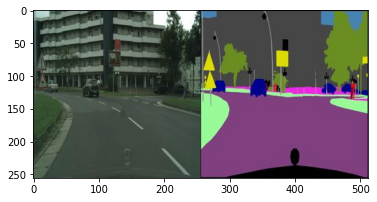

In [6]:
# An image example 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

img = mpimg.imread("/content/cityscapes/train/1.jpg")
imgplot = plt.imshow(img)
plt.show()

In [7]:
img.shape

(256, 512, 3)

In [8]:
# Create datasets and dataloader

# Both Datasetloader and ImageLoader look for subfolders in the root. Since we don't have that
# we will have to write a CustomDataset class

from PIL import Image
import natsort,os 
from torch.utils.data import Dataset

class CustomDataSet(Dataset):
    def __init__(self, root, transform):
      super().__init__()
      self.main_dir = root
      self.transform = transform
      all_imgs = os.listdir(root)
      self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
      return len(self.total_imgs)

    def __getitem__(self, idx):
      img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
      image = Image.open(img_loc).convert("RGB")
      tensor_image = self.transform(image)
      return tensor_image


batch_size = 32
workers = 2

train_dataset = CustomDataSet(root="/content/cityscapes/train",transform=transforms.Compose([
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

test_dataset = CustomDataSet(root="/content/cityscapes/val",transform=transforms.Compose([
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))                           
]))

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=workers)
test_dataloder = torch.utils.data.DataLoader(test_dataset,batch_size=10,shuffle=True,num_workers=workers)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

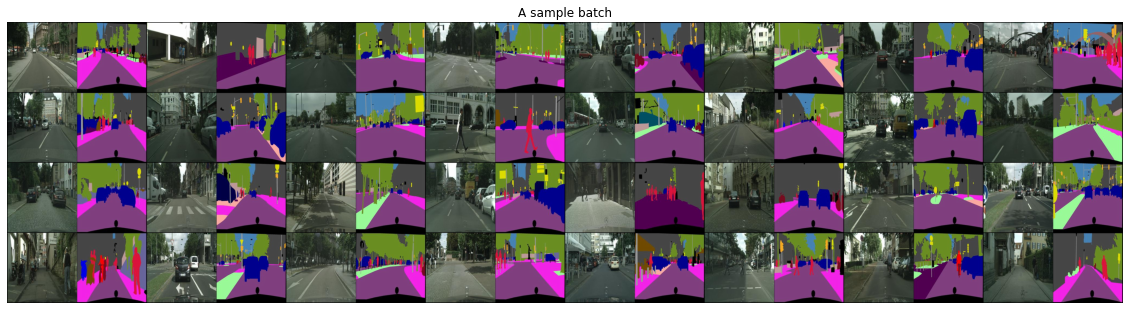

In [9]:
import torchvision.utils as vutils
print_batch = next(iter(train_dataloader))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("A sample batch")
plt.imshow(np.transpose(vutils.make_grid(print_batch.to(device),padding=2,normalize=True).cpu(),(1,2,0)))

In [10]:
class DownSample(nn.Module):
  def __init__(self,in_channels,out_channels,normalize=True,dropout=0.0):
    super().__init__()

    layers = [nn.Conv2d(in_channels,out_channels,4,2,1,bias=False)]
  
    if normalize: layers.append(nn.InstanceNorm2d(out_channels))      ,

    layers.append(nn.LeakyReLU(0.2,inplace=True)) # RELU in encoders are RELU

    if dropout: layers.append(nn.Dropout(dropout))

    self.network = nn.Sequential(*layers)
  def forward(self,input):
    return self.network(input)


class UpSample(nn.Module):
  def __init__(self,in_channels,out_channels,dropout=0.0):
    super().__init__()

    layers = [nn.ConvTranspose2d(in_channels,out_channels,4,2,1,bias=False),
              nn.InstanceNorm2d(out_channels),
              nn.ReLU(inplace=True)
              ]
    
    if dropout: layers.append(nn.Dropout(dropout))

    self.network = nn.Sequential(*layers)

  def forward(self,input,skip_connection): # skip connection from the corresponding encoder layer
    x = self.network(input)
    x = torch.cat([x,skip_connection],dim=1) # skip  connections  concatenate  activations  from  layer i to layer n−i
    
    return x

class Generator(nn.Module):
  def __init__(self,in_channels=3,out_channels=3):
    super().__init__()
    self.down1 = DownSample(in_channels,64,False)
    self.down2 = DownSample(64,128)
    self.down3 = DownSample(128,256)
    self.down4 = DownSample(256,512,dropout=0.5)
    self.down5 = DownSample(512,512,dropout=0.5)
    self.down6 = DownSample(512,512,dropout=0.5)
    self.down7 = DownSample(512,512,dropout=0.5)
    self.down8 = DownSample(512,512,normalize=False,dropout=0.5)

    self.up1 = UpSample(512,512,dropout=0.5)
    self.up2 = UpSample(1024,512,dropout=0.5)
    self.up3 = UpSample(1024,512,dropout=0.5)
    self.up4 = UpSample(1024,512,dropout=0.5)
    self.up5 = UpSample(1024,256)
    self.up6 = UpSample(512,128)
    self.up7 = UpSample(256,64)
    self.up8 = nn.Sequential(
        nn.ConvTranspose2d(128,out_channels,4,2,1,bias=False),
        nn.Tanh()
    )

  def forward(self,input):
    # Downsampling input
    d1 = self.down1(input)
    d2 = self.down2(d1)
    d3 = self.down3(d2)
    d4 = self.down4(d3)
    d5 = self.down5(d4)
    d6 = self.down6(d5)
    d7 = self.down7(d6)
    d8 = self.down8(d7)
    # Upsampling with skip connections
    u1 = self.up1(d8,d7)
    u2 = self.up2(u1,d6)
    u3 = self.up3(u2,d5)
    u4 = self.up4(u3,d4)
    u5 = self.up5(u4,d3)
    u6 = self.up6(u5,d2)
    u7 = self.up7(u6,d1)

    return self.up8(u7)

In [11]:
class Discriminator(nn.Module):
  '''
  I will implement the 70*70 PatchGAN discriminator here
  To understand how this architecture implements 70*70 patchGAN refer(Think receptive fields)
  https://sahiltinky94.medium.com/understanding-patchgan-9f3c8380c207
  '''
  def __init__(self,in_channels=3):
    # First conv for the concatenated images
    super().__init__()
    layers = []
    layers.append(nn.Conv2d((in_channels*2),64,4,2,1,bias=False)) # Dims for Cityscape data [N,6,256,256]-> [N,64,128,128]
    layers.append(nn.LeakyReLU(0.2)) 
    layers.extend(self.Dblock(64,128)) # [N,64,128,128] -> [N,128,64,64]
    layers.extend(self.Dblock(128,256)) # [N,128,64,64] -> [N,256,32,32]
    layers.extend(self.Dblock(256,512,4,1,1)) # [N,256,32,32] -> [N,512,31,31]
    layers.append(nn.Conv2d(512,1,4,1,1,bias=False)) # [N,512,31,31] -> [N,1,30,30]
    layers.append(nn.Sigmoid())
  
    self.network = nn.Sequential(*layers)

  def Dblock(self,in_channels,out_channels,k=4,s=2,p=1):
    layers = [nn.Conv2d(in_channels,out_channels,k,s,p,bias=False), # I am setting bias=False but nothing as such is mentioned in the paper
              nn.BatchNorm2d(out_channels),
              nn.LeakyReLU(0.2,inplace=True)
              ]
    return layers 

  def forward(self, image, label):
    x = torch.cat([image,label],dim=1)

    return self.network(x)

In [12]:
# Initialize Weight
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!= -1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm')!= -1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

In [13]:
# Using Test Set to check progress of generator
# Test set length
print(len(test_dataloder))

50


In [14]:
lr = 0.0002
beta1 = 0.5
pixel_lambda = 100

# loss criterion
gan_criterion = nn.BCELoss()
pixelwise_criterion = nn.L1Loss()

# Defining labels
real_label = 1.
fake_label = 0.

# Defining models
D = Discriminator().to(device)
D.apply(init_weights)

G = Generator().to(device)
G.apply(init_weights)

# Optimizers
G_optim = optim.Adam(G.parameters(),lr= lr,betas=(beta1,0.999))
D_optim = optim.Adam(D.parameters(),lr=lr,betas=(beta1,0.999))

In [15]:
# Training Loop
num_epochs = 5

img_list = []
G_losses = []
D_losses = []
iters = 0
discriminator_return_shape = [1,30,30] # For the implementation of 70*70 patchGAN these are the returned dims for Cityscape dataset

for epoch in range(num_epochs):
  for i,batch in enumerate(train_dataloader):

    # Training discriminator

    # checking real images
    D_optim.zero_grad() # Deliberately choosing to set model
    
    batch_size = batch.shape[0]
    width = batch.shape[-1]
    width = width//2

    # Splitting image coz both images are joined in one
    real = batch[:,:,:,:width].to(device)
    sketches = batch[:,:,:,width:].to(device)

    # Real Loss 
    real_predictions = D(real,sketches)

    labels = torch.ones((batch_size,*discriminator_return_shape),requires_grad=False).to(device)

    D_gan_loss_real = gan_criterion(real_predictions,labels)

    D_gan_loss_real = 0.5*(D_gan_loss_real)

    D_gan_loss_real.backward()
    
    # Fake loss
    fake_images = G(sketches)

    labels.fill_(fake_label)

    fake_predictions = D(fake_images.detach(),sketches)

    D_gan_loss_fake = gan_criterion(fake_predictions,labels)

    total_D_error = 0.5*(D_gan_loss_real + D_gan_loss_fake)

    D_gan_loss_fake = 0.5*D_gan_loss_fake

    D_gan_loss_fake.backward()
    # total_D_error.backward() 

    D_optim.step()


    # Training Generator

    G_optim.zero_grad()

    labels.fill_(real_label)

    # fooling the discriminator loss
    fake_predictions = D(fake_images,sketches)

    G_gan_loss = gan_criterion(fake_predictions,labels)

    # generator L1 loss
    G_l1_loss = pixelwise_criterion(fake_images,real)
    
    Gloss = G_gan_loss + pixel_lambda*G_l1_loss

    Gloss.backward()

    G_optim.step()

    # Printing losses and saving results for later

    if i%10 == 0:
      print(f'[{epoch}/{num_epochs}] [{i}/{len(train_dataloader)}] \t Loss D:{total_D_error.item():.4f} \t Loss G:{Gloss.item():.4f}\
       \t G L1 loss:{pixel_lambda*G_l1_loss:.4f}')
    
    G_losses.append(Gloss.item())
    D_losses.append(total_D_error.item())

    if (iters%300 == 0) or ((epoch==num_epochs-1) and (i==len(train_dataloader)-1)):
      with torch.no_grad():
        for i,batch_ in enumerate(test_dataloder):
          
          width_ = batch_.shape[-1]
          width_ = width_//2
          sketch = batch_[:,:,:,width_:].to(device)
          real = batch_[:,:,:,:width_].cpu()
          fake= G(sketch).detach().cpu()

          img_list.append(vutils.make_grid(torch.cat([fake,real],dim=1),padding=2,normalize=True,nrow=5,scale_each=True))
    iters += 1

[0/5] [0/93] 	 Loss D:0.7630 	 Loss G:55.2773       	 G L1 loss:53.7306
[0/5] [10/93] 	 Loss D:0.3540 	 Loss G:34.6691       	 G L1 loss:33.3903
[0/5] [20/93] 	 Loss D:0.3101 	 Loss G:26.1967       	 G L1 loss:24.4482
[0/5] [30/93] 	 Loss D:0.3731 	 Loss G:23.2398       	 G L1 loss:21.6706
[0/5] [40/93] 	 Loss D:0.3951 	 Loss G:22.2121       	 G L1 loss:20.8319
[0/5] [50/93] 	 Loss D:0.4706 	 Loss G:20.4794       	 G L1 loss:18.7171
[0/5] [60/93] 	 Loss D:0.3773 	 Loss G:21.0854       	 G L1 loss:19.5528
[0/5] [70/93] 	 Loss D:0.5215 	 Loss G:23.4298       	 G L1 loss:21.6835
[0/5] [80/93] 	 Loss D:0.4118 	 Loss G:23.9977       	 G L1 loss:21.8195
[0/5] [90/93] 	 Loss D:0.3488 	 Loss G:22.7981       	 G L1 loss:20.9073
[1/5] [0/93] 	 Loss D:0.3724 	 Loss G:22.0336       	 G L1 loss:20.3611
[1/5] [10/93] 	 Loss D:0.2237 	 Loss G:22.6501       	 G L1 loss:20.9510
[1/5] [20/93] 	 Loss D:0.2053 	 Loss G:21.3916       	 G L1 loss:20.1637
[1/5] [30/93] 	 Loss D:0.2401 	 Loss G:23.4159       

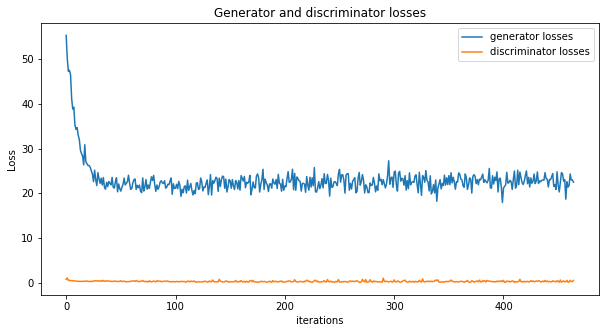

In [16]:
# Plotting discriminator and generator losses
plt.figure(figsize=(10,5))
plt.title("Generator and discriminator losses")
plt.plot(G_losses,label="generator losses")
plt.plot(D_losses,label="discriminator losses")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

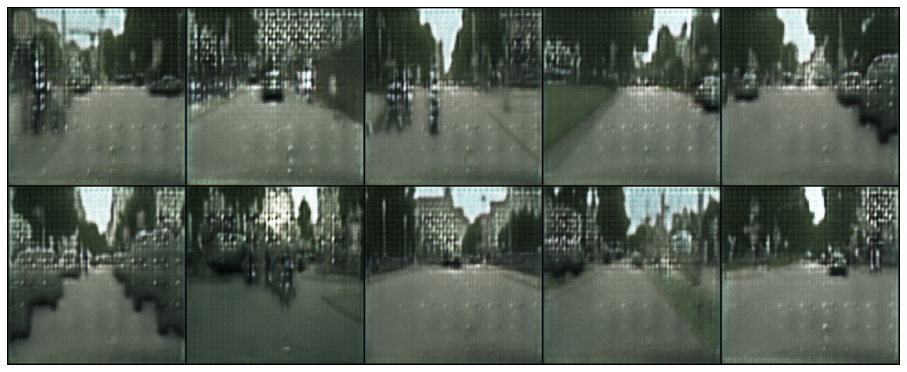

In [20]:
# Evolution of generator, Showing only fake images right now.
from IPython.display import HTML
import matplotlib
import matplotlib.animation as animation
matplotlib.rcParams['animation.embed_limit']=2**64
fig = plt.figure(figsize=(16,8))
plt.axis("off")
ims=[[plt.imshow(np.transpose(i[:3,:,:],(1,2,0)),animated=True)] for i in img_list[-2:]]
ani = animation.ArtistAnimation(fig,ims,interval=1000,repeat_delay=1000,blit=True)

HTML(ani.to_jshtml())



In [ ]:
len(img_list)